### Step by Step OIV 452-1 predictor Training

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from pathlib import Path
import shutil

from tqdm import tqdm

import pandas as pd

from sklearn.metrics import (
    confusion_matrix,
    mean_squared_error,
    ConfusionMatrixDisplay,
    classification_report,
)

import matplotlib.pyplot as plt
import altair as alt

import panel as pn

import com_const as cc
import com_func as cf
import com_augmentations as ca
import leaf_patch_oiv_predictor_model as lpopm

## Setup

In [3]:
# Remove warnings
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
pd.options.display.float_format = "{:4,.4f}".format

pd.set_option("display.max_colwidth", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 16)

In [5]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [6]:
pn.extension("plotly", "vega", notifications=True, console_output="disable")

NotificationArea()

## Dataset

### Load

In [7]:
train, val, test = [
    cf.read_dataframe(cc.path_to_data.joinpath(f"oiv_{d}.csv"))
    for d in ["train", "val", "test"]
]
alt.hconcat(
    *[
        alt.Chart(df.assign(oiv=lambda x: x.oiv.astype(str)))
        .mark_bar()
        .encode(x="oiv", y="count()", color="source", tooltip="count()")
        .properties(width=200, height=300, title=title)
        for (df, title) in [
            (train, "train"),
            (val, "val"),
            (test, "test"),
        ]
    ]
)

alt.HConcatChart(...)

### Augmentation
Selected augmentations are:
- Color transformations
- Brightness modifications
- Rotations
- Symetries

                          file_name  oiv
702  Exp21DM02_inoc1_T6_P21_a_3.png    1


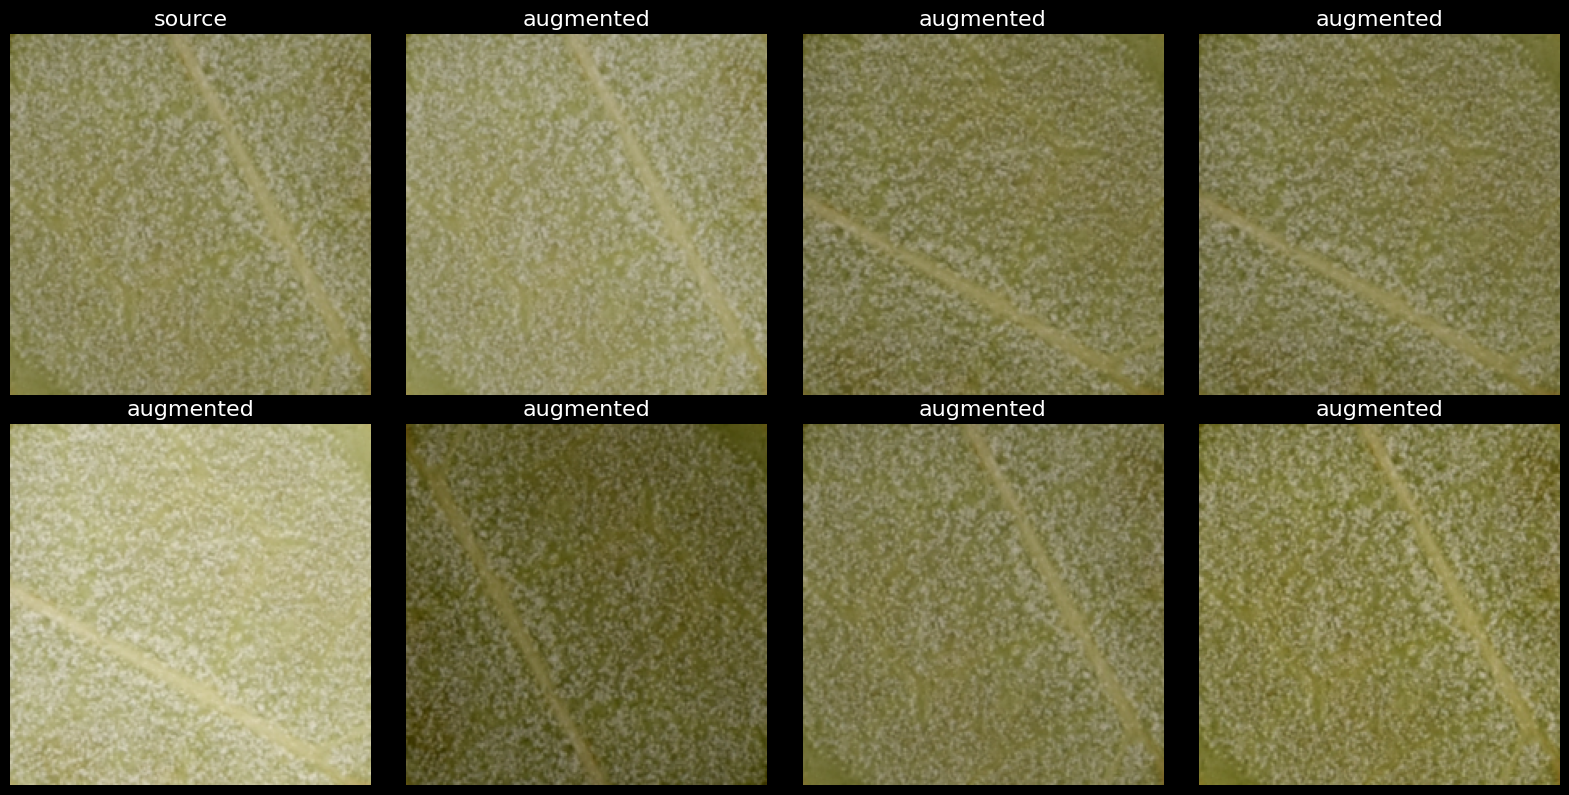

In [8]:
augmentations_kinds = ["fix_brightness", "resize", "affine", "color", "to_tensor"]
augmentations_params = dict(
    gamma=(60, 120),
    brightness_limit=0.15,
    contrast_limit=0.25,
    brightness_target=115,
    brightness_thresholds=(115, 130),
)

ca.test_augmentations(
    df=train,
    image_size=224,
    path_to_images=cc.path_to_leaf_patches,
    kinds=augmentations_kinds,
    columns=["oiv"],
    **augmentations_params
)

## Model

### Find Batch Size

In [9]:
batch_size = 615

We trained the models on an NVIDIA A100 80GB PCIe that allowed us a batch size of 769 that we reduced to 615 t avoid monopolizing the GPU. Uncomment the the following block to calculate optimal batch size

In [10]:
# batch_size = lpopm.get_bs(
#     batch_size=300,
#     train=train,
#     val=val,
#     test=test,
#     augmentations_kinds=augmentations_kinds,
#     augmentations_params=augmentations_params,
#     shrink_factor=0.8,
# )

In [11]:
batch_size

615

### Find Learning Rate

In [12]:
learning_rate = 0.000363

We found that we our selected batch size the best learning rate was 0.000363. The function hereafter will calculate on optimal learning rate for your setup.

In [13]:
# learning_rate = lpopm.get_lr(
#     train=train,
#     val=val,
#     test=test,
#     augmentations_params=augmentations_params,
#     augmentations_kinds=augmentations_kinds,
#     batch_size=batch_size,
#     lr_times=10,
# )


In [14]:
learning_rate

0.000363

### Train

In [ ]:
lpopm.train_model(
    path_to_images=cc.path_to_leaf_patches,
    train=train,
    val=val,
    test=test,
    monitor_loss="mse",
    augmentations_kinds=augmentations_kinds,
    augmentations_params=augmentations_params,
    batch_size=batch_size,
    learning_rate=learning_rate,
)

### Validate

In [15]:
model = lpopm.OivDetPatchesNet.load_from_checkpoint(
    cc.path_to_chk_oiv.joinpath("oiv_scorer.ckpt")
)
model.path_to_images = cc.path_to_leaf_patches
model.hr_desc()

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

                       oiv_fixed_oiv_hf_swt_t_mae_corn params & values                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                    Param ┃ Value                                                           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                 backbone │ 'hf_swt_t'                                                      │
│            predicted_var │ 'fixed_oiv'                                                     │
│             invert_scale │ False                                                           │
│              skip_linear │ False                                                           │
│              use_sigmoid │ False                                                           │
│             monitor_loss │ 'mae'                                                           │
│       val_monitor_target │ 'val_monitor'                                                   │
│         val_monitor_mode │ 'min'                                                           │
│ ordinal_regression_model │ 'corn'                                                          │
│                     path │ 'microsoft/swin-tiny-patch4-window7-224'                        │
│                     name │ 'Swin Transformer (tiny-sized model)'                           │
│                     link │ 'https://huggingface.co/microsoft/swin-tiny-patch4-window7-224' │
│               batch_size │ 616                                                             │
│               image_size │ 224                                                             │
│      augmentations_kinds │ ['fix_brightness', 'resize', 'affine', 'color', 'to_tensor']    │
│     augmentations_params │ {                                                               │
│                          │     'gamma': (60, 120),                                         │
│                          │     'brightness_limit': 0.15,                                   │
│                          │     'contrast_limit': 0.25,                                     │
│                          │     'brightness_target': 115,                                   │
│                          │     'brightness_thresholds': (115, 130),                        │
│                          │     'mean': (0.5, 0.5, 0.5),                                    │
│                          │     'std': (0.5, 0.5, 0.5)                                      │
│                          │ }                                                               │
│         Conv output size │ 5                                                               │
│        exclude_if_source │ '[]'                                                            │
│           path_to_images │ images/leaf_patches                                             │
│        include_if_source │ ['dark_images' 'good_images' 'water_images']                    │
│              weight_loss │ False                                                           │
│            learning_rate │ 0.00036253727772139874                                          │
│                 start_lr │ 0.00036253727772139874                                          │
│                optimizer │ 'adam'                                                          │
│                scheduler │ 'steplr'                                                        │
│         scheduler_params │ {'step_size': 6, 'gamma': 0.85}                                 │
│                    train │ (2414, 37)                                                      │
│                      val │ (518, 37)                                                       │
│                     test │ (517, 37)                                                       │
│              data_source │ 'raw_dataset'                                                   │
└─────────

Predicting: 100%|██████████| 517/517 [00:25<00:00, 19.94it/s]


MSE: 0.203


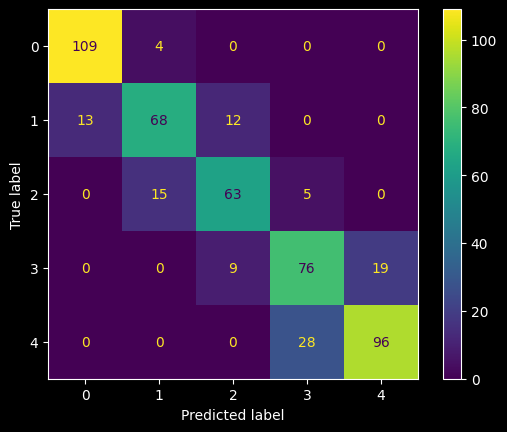

In [16]:
test_data = model.test_data.assign(oiv=lambda x :x.fixed_oiv)
test_data["p_oiv"] = model.predict(test_data)

print(f"MSE: {mean_squared_error(test_data.oiv.astype(int), test_data.p_oiv.astype(int)):.3f}")
ConfusionMatrixDisplay.from_predictions(
    test_data.oiv.astype(int), test_data.p_oiv.astype(int)
);